# Analysing Children Data

### Loading libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from datetime import timedelta

### Loading the datasets

In [2]:
children = pd.read_csv("data_children.csv")
df_weighted = pd.read_csv("weight_subscores.csv")

Session 1 scores will be taken as the baseline scores. First, we wish to check the relationship of the baseline scores with the hair and saliva cortisol levels. Second, we would be checking the predictive relationship of baseline subluxation levels and the hair and saliva cortisol levels. We will assume baseline subluxation as the independent variable, and the hair and saliva cortisol levels as the dependent variables.

we will also extract the subluxation scores for each patient's last session and will create a new column with these values. These will act as the subluxation scores after the 12 week intervention.

In [3]:
# Step 1: Select only columns containing "Weighted Sum"
weighted_sum_cols = [col for col in df_weighted.columns if "Weighted Sum" in col]

# Step 2: Get the last non-zero value in each row from selected columns
df_weighted['Last Intervention Score'] = df_weighted[weighted_sum_cols].apply(
    lambda row: row[row != 0].dropna().iloc[-1] if (row[row != 0].dropna().size > 0) else None, axis=1
)

# Step 3: Extract session time columns (excluding Weighted Sum ones)
time_cols = [col for col in df_weighted.columns if col.startswith('Session') and 'Weighted Sum' not in col]

# Step 4: Convert session time strings to datetime (ISO format like '2022-04-22 13:50:00')
df_time = df_weighted[time_cols].apply(pd.to_datetime, errors='coerce')

# Step 5: Get the first session date per row
first_session = df_time.min(axis=1)

# Step 6: Initialize the new column
df_weighted['Mid Intervention Score'] = None

# Step 7: Loop to extract the score 42 days after the first session
for idx in df_weighted.index:
    base_date = first_session.loc[idx]
    if pd.isnull(base_date):
        continue

    # Target is 42 days after base
    target_date = base_date + timedelta(days=42)

    # Get session columns on or after this date
    session_times = df_time.loc[idx]
    future_sessions = session_times[session_times >= target_date].sort_values()

    if not future_sessions.empty:
        session_col = future_sessions.index[0]  # Get first session after 42 days
        weighted_sum_col = session_col + ' Weighted Sum'

        if weighted_sum_col in df_weighted.columns:
            df_weighted.at[idx, 'Mid Intervention Score'] = df_weighted.at[idx, weighted_sum_col]

# Resulting DataFrame
df_weighted

,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 2,Session 2 Weighted Sum,Session 3,...,Session 33,Session 33 Weighted Sum,Session 34,Session 34 Weighted Sum,Session 35,Session 35 Weighted Sum,Session 36,Session 36 Weighted Sum,Last Intervention Score,Mid Intervention Score
0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,26,2022-04-22 13:50:00,22,2022-04-25 14:45:00,...,NaT,0,NaT,0,NaT,0,NaT,0,10,21
1,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,19,2022-04-22 08:50:00,25,2022-04-23 09:20:00,...,NaT,0,NaT,0,NaT,0,NaT,0,16,16
2,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,17,2022-04-20 11:50:00,19,2022-04-23 10:06:00,...,NaT,0,NaT,0,NaT,0,NaT,0,12,20
3,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,25,2022-04-22 12:55:00,24,2022-04-25 14:20:00,...,NaT,0,NaT,0,NaT,0,NaT,0,12,9
4,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,24,2022-04-22 12:45:00,22,2022-04-25 15:00:00,...,NaT,0,NaT,0,NaT,0,NaT,0,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,243,NaN,NaN,Children,Passive,2022-06-06 10:48:00,21,2022-06-21 12:17:00,12,2022-07-27 12:17:00,...,NaT,0,NaT,0,NaT,0,NaT,0,12,12
199,247,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:48:00,25,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,18,19
200,248,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:53:00,27,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,18,29
201,249,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:56:00,18,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,20,28


We will do the above for the chikdren data as well to assess the results separately later.

In [4]:
# Step 1: Select only columns containing "Weighted Sum"
weighted_sum_cols = [col for col in children.columns if "Weighted Sum" in col]

# Step 2: Get the last non-zero value in each row from selected columns
children['Last Intervention Score'] = children[weighted_sum_cols].apply(
    lambda row: row[row != 0].dropna().iloc[-1] if (row[row != 0].dropna().size > 0) else None, axis=1
)

# Step 3: Extract session time columns (excluding Weighted Sum ones)
time_cols = [col for col in children.columns if col.startswith('Session') and 'Weighted Sum' not in col]

# Step 4: Convert session time strings to datetime (ISO format like '2022-04-22 13:50:00')
df_time = children[time_cols].apply(pd.to_datetime, errors='coerce')

# Step 5: Get the first session date per row
first_session = df_time.min(axis=1)

# Step 6: Initialize the new column
children['Mid Intervention Score'] = None

# Step 7: Loop to extract the score 42 days after the first session
for idx in children.index:
    base_date = first_session.loc[idx]
    if pd.isnull(base_date):
        continue

    # Target is 42 days after base
    target_date = base_date + timedelta(days=42)

    # Get session columns on or after this date
    session_times = df_time.loc[idx]
    future_sessions = session_times[session_times >= target_date].sort_values()

    if not future_sessions.empty:
        session_col = future_sessions.index[0]  # Get first session after 42 days
        weighted_sum_col = session_col + ' Weighted Sum'

        if weighted_sum_col in df_weighted.columns:
            children.at[idx, 'Mid Intervention Score'] = children.at[idx, weighted_sum_col]

# Resulting DataFrame
children

,Unnamed: 0,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 1 Cervical,Session 1 Lumbar,...,Session 36 Thoracic,Group,Gender,Hair Cortisol Baseline,Hair Cortisol FollowUp,Saliva Cortisol Baseline,Saliva Cortisol Intervention,Saliva Cortisol FollowUp,Last Intervention Score,Mid Intervention Score
0,57,136,NaN,NaN,Children,Active,NaT,0,0,0,...,0,1,1,20,20.0,1.690,34.434,8.235,11,23
1,58,139,NaN,NaN,Children,Active,2022-05-31 16:33:00,23,15,0,...,0,1,1,132,163.0,1.570,11.840,10.238,10,23
2,59,141,NaN,NaN,Children,Active,2022-05-31 16:38:00,26,18,0,...,0,1,1,20,43.0,5.231,11.235,9.573,11,26
3,60,142,30/5,3X4,Children,Active,2022-05-30 17:04:00,24,15,3,...,0,1,1,20,76.0,1.500,25.842,11.795,10,24
4,61,144,30/5,3X4,Children,Active,2022-05-30 16:10:00,26,18,3,...,0,1,1,56,218.0,4.235,30.772,18.523,10,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,198,243,NaN,NaN,Children,Passive,2022-06-06 10:48:00,21,13,0,...,0,2,2,114,32.0,7.235,14.235,15.421,12,21
76,199,247,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:48:00,25,13,0,...,0,2,1,119,20.0,6.214,11.179,15.236,18,25
77,200,248,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:53:00,27,15,0,...,0,2,1,35,20.0,12.240,13.238,NaN,18,27
78,201,249,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:56:00,18,10,2,...,0,2,1,155,109.0,15.846,12.253,28.046,20,18


### Correlation between the variables

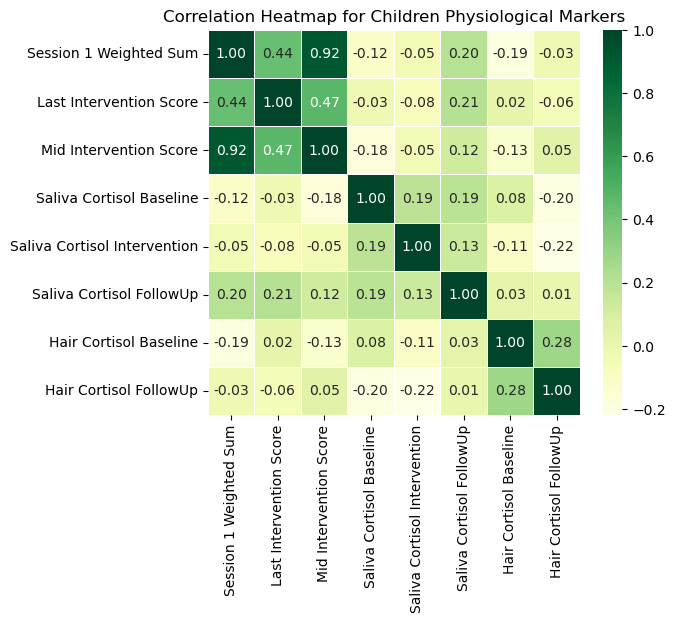

In [5]:
# Select specific columns
columns_to_plot = ["Session 1 Weighted Sum", "Last Intervention Score", "Mid Intervention Score", 
                   "Saliva Cortisol Baseline", "Saliva Cortisol Intervention", "Saliva Cortisol FollowUp", 
                   "Hair Cortisol Baseline", "Hair Cortisol FollowUp"]  
corr_matrix = children[columns_to_plot].corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Children Physiological Markers")
plt.show()

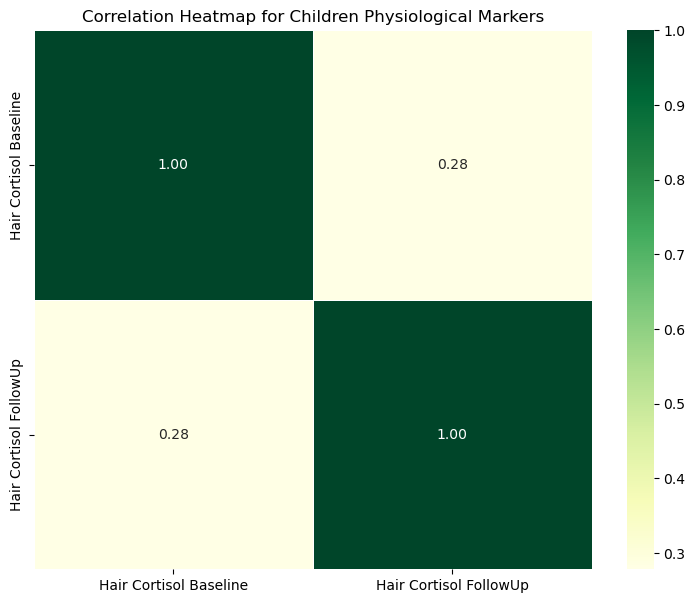

In [6]:
# Select specific columns
columns_to_plot = ["Hair Cortisol Baseline", "Hair Cortisol FollowUp"]  
corr_matrix = children[columns_to_plot].corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Children Physiological Markers")
plt.show()

In [7]:
# Fill missing values
children_filled = children.fillna(0)

# Step 2: Encode Active/Passive
children_filled['Active_Passive_Encoded'] = children_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
children_filled['Active_Passive_Encoded'] = children_filled['Active_Passive_Encoded'].fillna(0)

children_filled = children_filled[children_filled["Active/Passive"] != 0]
print(children_filled["Active/Passive"].value_counts())

Active/Passive
Active     43
Passive    37
Name: count, dtype: int64


In [8]:
# 2. Rename columns
children_filled = children_filled.rename(columns={
    "Last Intervention Score": "Last_Intervention_Score",
    "Active/Passive":  "ActivePassive",
    "Mid Intervention Score": "Mid_Intervention_Score",
    "Saliva Cortisol Baseline": "Saliva_Cortisol_Baseline",
    "Hair Cortisol Baseline": "Hair_Baseline"
})

In [9]:
import numpy as np

# Assuming your DataFrame is called df and the column to transform is 'your_variable'
children_filled['SalivaBaseline_log'] = np.log(children_filled['Saliva_Cortisol_Baseline'] + 1)
children_filled['SalivaFollow_log'] = np.log(children_filled['Saliva Cortisol FollowUp'] + 1)
children_filled['HairBaseline_log'] = np.log(children_filled['Hair_Baseline'] + 1)
children_filled['HairFollow_log'] = np.log(children_filled['Hair Cortisol FollowUp'] + 1)
children_filled['SalivaPost_log'] = np.log(children_filled['Saliva Cortisol Intervention'] + 1)
children_filled['LastScore_log'] = np.log(children_filled['Last_Intervention_Score'] + 1)

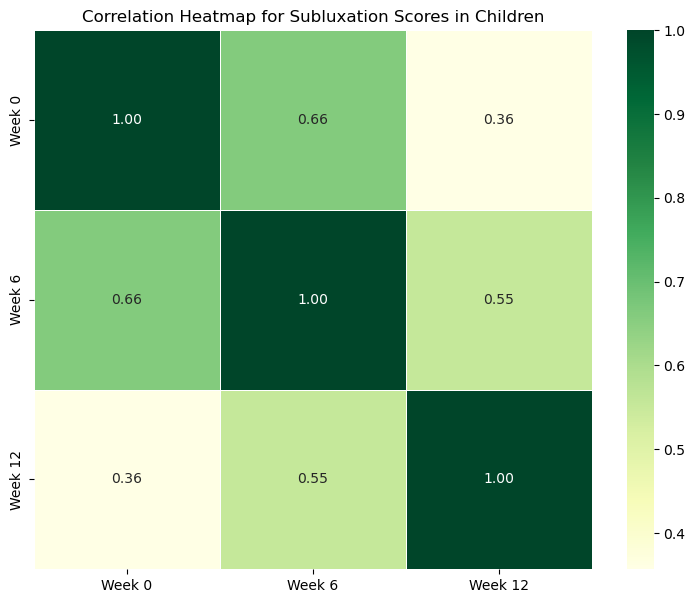

In [10]:
# Select and rename columns for display
columns_to_plot = [
    "Session 1 Weighted Sum",  
    "Mid_Intervention_Score",
    "Last_Intervention_Score"
]

# Compute correlation matrix
corr_matrix = children_filled[columns_to_plot].corr()

# Rename for heatmap display
display_labels = {
    "Session 1 Weighted Sum": "Week 0",
    "Mid_Intervention_Score": "Week 6",
    "Last_Intervention_Score": "Week 12"
}

# Apply new labels
corr_matrix.rename(index=display_labels, columns=display_labels, inplace=True)

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Subluxation Scores in Children")
plt.show()

# Log Transformed

In [18]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = children_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")

# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", SalivaCortisol_Long=df["SalivaBaseline_log"]),
    df.assign(Timepoint="PostIntervention", SalivaCortisol_Long=df["SalivaPost_log"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "SalivaCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "HairBaseline_log"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# ----------------------------
# 4. Mixed effects model
# ----------------------------
model = smf.mixedlm(
    "SalivaCortisol_Long ~ Timepoint + HairBaseline_log +  C(ActivePassive) + Mid_Intervention_Score + Last_Intervention_Score",
    df_final,
    groups=df_final["ID"],
     re_formula="~Timepoint"
)
result = model.fit()
print(result.summary())

                       Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       SalivaCortisol_Long
No. Observations:        160           Method:                   REML               
No. Groups:              80            Scale:                    0.1448             
Min. group size:         2             Log-Likelihood:           -118.8740          
Max. group size:         2             Converged:                Yes                
Mean group size:         2.0                                                        
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  2.180    0.322  6.770 0.000  1.549  2.811
Timepoint[T.PostIntervention]              0.821    0.070 11.651 0.000  0.683  0.959
C(Ac

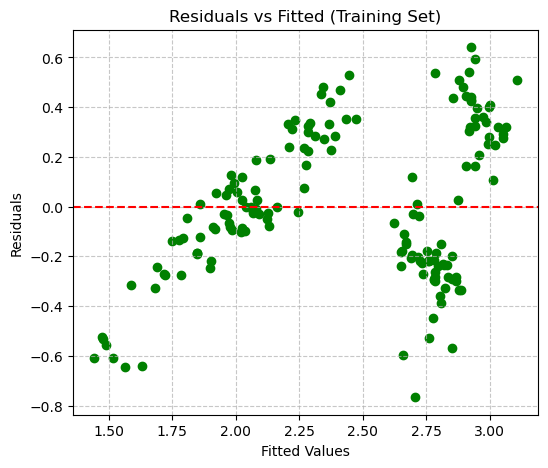

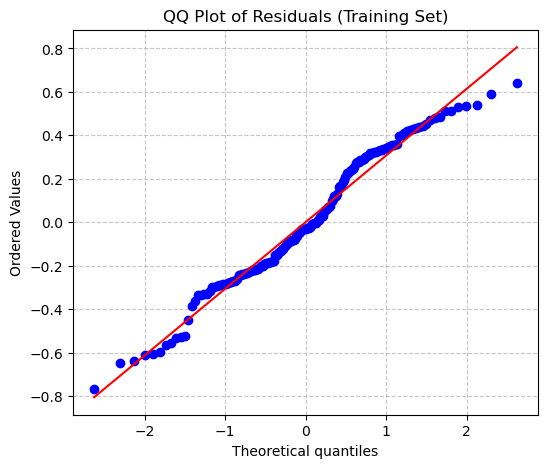

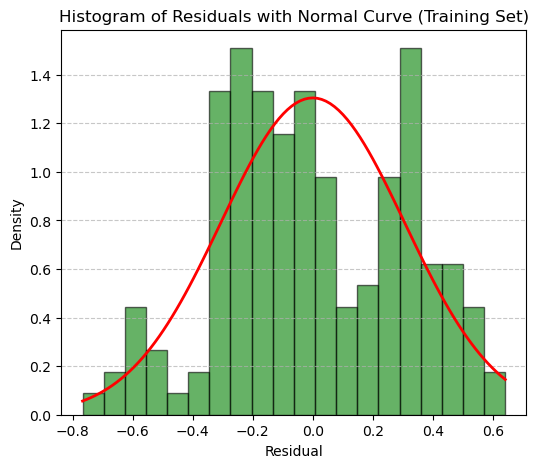

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

# Calculate fitted values and residuals
fitted_vals = result.fittedvalues
residuals = df_final["SalivaCortisol_Long"] - fitted_vals

# Store in dataframe
df_final["Fitted"] = fitted_vals
df_final["Residual"] = residuals

# 1. Residuals vs Fitted plot
plt.figure(figsize=(6, 5))
plt.scatter(df_final["Fitted"], df_final["Residual"], color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. QQ plot of residuals
plt.figure(figsize=(6, 5))
stats.probplot(df_final["Residual"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Training Set)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Histogram of residuals with normal curve
mu, std = np.mean(residuals), np.std(residuals)

plt.figure(figsize=(6, 5))
count, bins, ignored = plt.hist(residuals, bins=20, density=True,
                                 edgecolor='black', alpha=0.6, color='green')

x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r', linewidth=2)

plt.title("Histogram of Residuals with Normal Curve (Training Set)")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
# Variance of fixed effects predictions
y_fixed = result.fittedvalues  # Predictions using fixed effects
var_fixed = np.var(y_fixed)

# Residual (within-group) variance
var_resid = result.scale

# Random effect variance (between-group)
var_random = result.cov_re.iloc[0, 0]

# Marginal R²: fixed / total
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R²: (fixed + random) / total
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R² (fixed effects only): {r2_marginal:.3f}")
print(f"Conditional R² (fixed + random effects): {r2_conditional:.3f}")

Marginal R² (fixed effects only): 0.440
Conditional R² (fixed + random effects): 0.516


In [17]:
import pandas as pd
import statsmodels.formula.api as smf

# Original dataset
df = children_filled.copy()

# ----------------------------
# 1. Melt score and time columns
# ----------------------------
score_cols = [f"Session {i} Weighted Sum" for i in range(1, 37)]
time_cols = [f"Session {i}" for i in range(1, 37)]

# Melt scores
df_scores = df[["ID"] + score_cols].melt(id_vars="ID", var_name="Session", value_name="Score")
df_scores["SessionNum"] = df_scores["Session"].str.extract("(\d+)").astype(int)

# Melt times
df_times = df[["ID"] + time_cols].melt(id_vars="ID", var_name="Session", value_name="Timestamp")
df_times["SessionNum"] = df_times["Session"].str.extract("(\d+)").astype(int)
df_times["Timestamp"] = df_times["Timestamp"].astype(str).str.strip()
df_times["Timestamp"] = df_times["Timestamp"].replace(["0", "", "nan", "NaT", "None"], pd.NA)
df_times["Timestamp"] = pd.to_datetime(df_times["Timestamp"], errors="coerce")

# Merge scores and times
df_long_scores = pd.merge(df_scores, df_times, on=["ID", "SessionNum"])
df_long_scores = df_long_scores.dropna(subset=["Timestamp"])  # drop missing timestamps

# ----------------------------
# 2. Create long-format cortisol data
# ----------------------------
df_cortisol = pd.concat([
    df.assign(Timepoint="Baseline", SalivaCortisol_Long=df["Saliva_Cortisol_Baseline"]),
    df.assign(Timepoint="PostIntervention", SalivaCortisol_Long=df["Saliva Cortisol Intervention"])
], ignore_index=True)

df_cortisol = df_cortisol[[
    "ID", "Timepoint", "SalivaCortisol_Long", "Last_Intervention_Score", "ActivePassive",
    "Mid_Intervention_Score", "Hair_Baseline"
]]

# ----------------------------
# 3. Merge cortisol + session timeline data (optional)
# ----------------------------
# If you want to model with session timing as a variable, merge it; else skip
df_final = pd.merge(df_cortisol, df_long_scores[["ID", "Timestamp"]].drop_duplicates("ID"), on="ID", how="left")

# ----------------------------
# 4. Mixed effects model
# ----------------------------
model = smf.mixedlm(
    "SalivaCortisol_Long ~ Timepoint + Hair_Baseline +  C(ActivePassive) + Mid_Intervention_Score + Last_Intervention_Score",
    df_final,
    groups=df_final["ID"],
     re_formula="~Timepoint"
)
result = model.fit()
print(result.summary())

                       Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       SalivaCortisol_Long
No. Observations:        160           Method:                   REML               
No. Groups:              80            Scale:                    14.8394            
Min. group size:         2             Log-Likelihood:           -510.3101          
Max. group size:         2             Converged:                Yes                
Mean group size:         2.0                                                        
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  8.969    2.720  3.297 0.001  3.637 14.301
Timepoint[T.PostIntervention]             10.191    0.963 10.583 0.000  8.304 12.078
C(Ac